In [1]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

from mesa.batchrunner import batch_run

from mesa.space import PropertyLayer

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import SingleGrid
from mesa.space import MultiGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import BaseScheduler

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos
# del modelo.
#%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# seaborn lo usaremos desplegar una gráficas más ''vistosas'' de
# nuestro modelo
import seaborn as sns

import random


# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

import heapq

In [3]:
#Clase de los dinosaurios
class Dino(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.id = unique_id #Id de los agentes
        self.position = self.pos #Guarda la ultima posicion de los agentes
        self.isCarring = False #Boleano que indica si el agente esta actualmente cargando a una victima
        self.advancePoints = 4 #Puntos de avence
        self.addedAdvancePoints = 0 #Puntos de avance extra
        self.routes = [] #Ruta del agente



    def step(self):
      self.move()

    def move(self):
      #Esta funcion se encarga de mover a los agentes dependiendo si estos estan actualmente cargando o no a una victima
      #En caso de que se esten moviendo sin una victima estos se moveran al punto de interes mas cercano, apagando humo o fuego que se vayan encontrando en el camino
      #En caso de que si lleven una victima, se moveran al punto de salida mas cercano a su posicion

      #Si lleva una vitcima
      if self.isCarring:
        ap = np.random.randint(1, (self.advancePoints + self.addedAdvancePoints)+1)
        #Obtiene la ruta mas cercana hacia la salida
        routes = self.get_exit(self.model.entrance)
        del routes[0]

        #Se mueve
        self.actionMove(1, routes)
        self.isFire()

        if len(routes) == 0:
          self.isCarring = False
          self.model.rescatadas += 1

      else:
        if not(len(self.model.poi) == 0):
          ap = np.random.randint(1, (self.advancePoints + self.addedAdvancePoints)+1)
          #Obtiene la ruta hacia el POI mas cercano
          routes = self.get_directions_poi(self.model.poi)
          del routes[0]

          #Se mueve
          self.actionMove(1, routes)
          #Apaga el fuego o revisa si hay un punto de interes en la casilla en la que se encuentra
          self.isPOI()
          self.isFire()
          self.position = self.pos

    def get_exit(self, array):
      #Esta funcion se encarga de regresar la lista con la ruta que debe de seguir el agente para llegar a la salida mas cercana

      temp = []
      #Se le resta 1 a las coordenas porque el tablero de mesa se bas en 0,0 como origen
      for i in range(len(array)):
        temp.append(tuple([array[i][0]-1, array[i][1]-1]))
      
      return self.dijkstra(self.model.grafo, self.pos, temp)

    def get_directions_poi(self, array):
      #Esta funcion se encarga de regresar la lista con la ruta que debe de seguir el agente para llegar al POI mas cercano
      
      temp = []
      #Se le resta 1 a las coordenas porque el tablero de mesa se bas en 0,0 como origen
      for i in range(len(array)):
        temp.append(tuple([array[i][0][0]-1, array[i][0][1]-1]))

      return self.dijkstra(self.model.grafo, self.pos, temp)

    def actionMove(self, ap, ruta):
      #Esta funcion le permite al agente moverse hacia la ruta en especifico a la que debe dirigirse

      if not(len(ruta) == 0): #Mientras aun exista ruta a la que ir
        flag = self.isWall(self.pos, ruta[0]) #Se revisa si hay obstaculos como muro o puertas y se mueve 
    
    def isFire(self):
      #Esta funcion revisa si la posicion en la que se encuentra el agente es un fuego y lo apaga en caso verdadero

      posicion = tuple([self.pos[0]+1, self.pos[1]+1])
      if posicion in self.model.fire:
        del self.model.fire[self.model.fire.index(posicion)]

    def isPOI(self):
      #Esta funcion verifica si la casilla en la que se encuentra el agente actualmente tiene un punto de interes
      #Revela el punto de interes y si es una victima se la lleva

      position = tuple([self.pos[0]+1, self.pos[1]+1])

      for poi in self.model.poi:
        if position == poi[0]: #Si coincide que hay un POI en donde esta el agente
          if poi[1]:#Si es una victima se la lleva y activa su boleano
            self.isCarring = True
            self.model.poi.remove([position, True])#Lo quita de la lista de POI
          else:
            #Si solo es una falsa alarma se quita de la lista de POI
            self.model.poi.remove([position, False])

    def isWall(self, cell, next):
      #La siguiente funcion verifica si la casilla a la cual el agente desea moverse es algun tipo de muro o puerta
      #Si es una puerta, el agente abre la puerta (se modifica el mapa del tablero indicando la apertura de la puerta)
      #Si es una pared, el agente rompe la pared para poder pasar

      #Extrae la casilla del mapa
      direction = self.model.map[cell[0]][cell[1]]

      #Revisa hacia que orientacion se quiere mover el agente (arriba, abajo, izq o der)
      result = ((cell[0]-next[0]), (cell[1]-next[1]))


      #Movimiento abajo hacia arriba
      if result == (1, 0):
        if direction[0] == "1": # Si hay un muro en la direcion a moverse
          if self.model.isDoor(self.pos, next, 0): #Si hay una puerta en la celda
            #Modifica los valores de las paredes en el mapa, abriendo la puerta
            self.model.map[cell[0]][cell[1]] = "0" + direction[1:]

            direction = self.model.map[next[0]][next[1]]
            self.model.map[next[0]][next[1]] = direction[:-2] + "0" + direction[-1]
            
            #Se mueve
            self.model.grid.move_agent(self, next)
            return True
          else:
            #Se rompe el muro, actualizando el mapa y añadiendo dos puntos de daño
            self.model.damageWall(2)
            self.model.destroyWalls(tuple([next[0]+1, next[1]+1]), tuple([cell[0]+1, cell[1]+1]))
            self.model.destroyWalls(tuple([next[0]+1, next[1]+1]), tuple([cell[0]+1, cell[1]+1]))
            return False

        else:
          #Si el espacio esta libre, se mueve con libertad
          self.model.grid.move_agent(self, next)

          return True

      #Movimiento derecha a izquierda
      elif result == (0, 1):
        if direction[1] == "1":
          if self.model.isDoor(self.pos, next, 3): #Si hay una puerta en la celda
            #Modifica los valores de las paredes en el mapa, abriendo la puerta
            self.model.map[cell[0]][cell[1]] = direction[0] + "0" + direction[2:]

            direction = direction = self.model.map[next[0]][next[1]]
            self.model.map[next[0]][next[1]] = direction[:-1] + "0"

            #Se mueve
            self.model.grid.move_agent(self, next)
            return True
          else:
            #Se rompe el muro, actualizando el mapa y añadiendo dos puntos de daño
            self.model.damageWall(2)
            self.model.destroyWalls(tuple([next[0]+1, next[1]+1]), tuple([cell[0]+1, cell[1]+1]))
            self.model.destroyWalls(tuple([next[0]+1, next[1]+1]), tuple([cell[0]+1, cell[1]+1]))
            return False

        else:
          #Si el espacio esta libre, se mueve con libertad
          self.model.grid.move_agent(self, next)

          return True

      #Movimiento arriba hacia abajo
      elif result == (-1, 0): #Horizontal
        if direction[2] == "1":
          if self.model.isDoor(self.pos, next, 1): #Si hay una puerta en la celda
            #Modifica los valores de las paredes en el mapa, abriendo la puerta
            self.model.map[cell[0]][cell[1]] = direction[:-2] + "0" + direction[-1]

            direction = self.model.map[next[0]][next[1]]
            self.model.map[next[0]][next[1]] =  "0" + direction[1:]


            #Se mueve
            self.model.grid.move_agent(self, next)
            return True
          else:
            ##Se rompe el muroa, actualizando el mapa y añadiendo dos puntos de daño
            self.model.damageWall(2)
            self.model.destroyWalls(tuple([cell[0]+1, cell[1]+1]), tuple([next[0]+1, next[1]+1]))
            self.model.destroyWalls(tuple([cell[0]+1, cell[1]+1]), tuple([next[0]+1, next[1]+1]))
            return False

        else:
          #Si el espacio esta libre, se mueve con libertad
          self.model.grid.move_agent(self, next)

          return True

      #Movimiento izq a derecha
      elif result == (0, -1):
        if direction[3] == "1":#Vertical
          if self.model.isDoor(self.pos, next, 2): #Si hay una puerta en la celda
            #Modifica los valores de las paredes en el mapa, abriendo la puerta
            self.model.map[cell[0]][cell[1]] = direction[:-1] + "0"

            direction = self.model.map[next[0]][next[1]]
            self.model.map[next[0]][next[1]] = direction[0] + "0" + direction[2:]

            #Se mueve
            self.model.grid.move_agent(self, next)
            return True
          else:
            #Se rompe el muro, actualizando el mapa y añadiendo dos puntos de daño
            self.model.damageWall(2)
            self.model.destroyWalls(tuple([cell[0]+1, cell[1]+1]), tuple([next[0]+1, next[1]+1]))
            self.model.destroyWalls(tuple([cell[0]+1, cell[1]+1]), tuple([next[0]+1, next[1]+1]))
            return False

        else:
          #Si el espacio esta libre, se mueve con libertad
          self.model.grid.move_agent(self, next)

          return True
      else:
        return False

    # Función para encontrar el camino más corto usando el algoritmo de Dijkstra
    def dijkstra(self, grafo, inicio, puntos_interes):
      # Usamos una cola de prioridad para manejar los nodos a explorar
      cola = [(0, inicio)]  # (distancia acumulada, nodo actual)
      distancias = {nodo: float('inf') for nodo in grafo}  # Inicializamos las distancias con infinito
      distancias[inicio] = 0
      previos = {nodo: None for nodo in grafo}  # Para reconstruir el camino
      visitados = set()

      while cola:
          distancia_actual, nodo_actual = heapq.heappop(cola)
          if nodo_actual in visitados:
              continue
          visitados.add(nodo_actual)

          # Si llegamos a un punto de interés, terminamos
          if nodo_actual in puntos_interes:
              break

          for vecino, peso in grafo[nodo_actual]:
              nueva_distancia = distancia_actual + peso
              if nueva_distancia < distancias[vecino]:
                  distancias[vecino] = nueva_distancia
                  previos[vecino] = nodo_actual
                  heapq.heappush(cola, (nueva_distancia, vecino))


      # Buscar el punto de interés más cercano
      punto_cercano = min(puntos_interes, key=lambda p: distancias[p])
      # Reconstruir el camino desde el punto más cercano
      camino = []
      nodo = punto_cercano
      while nodo is not None:
          camino.append(nodo)
          nodo = previos[nodo]

      return camino[::-1]  # Devolver el camino en orden correcto


In [4]:
def get_grid(model):
  temp = []
  for i in model.poi:
    temp.append(i[0])

  grid = np.zeros( (model.grid.width, model.grid.height) )
  for (content, (x, y)) in model.grid.coord_iter():
      if (content):
        grid[x][y] = 1
      elif (x+1, y+1) in temp:
        grid[x][y] = 2
      
      elif tuple([x+1, y+1]) in model.smokes:
        grid[x][y] = 3
      elif (x+1, y+1) in model.fire:
        grid[x][y] = 4
      else:
        grid[x][y] = 0

  return grid

In [5]:
#Modelo del tablero
class Board(Model):
  def __init__(self, width, height, array):
    super().__init__()
    self.grid = MultiGrid(width, height, True)
    self.schedule = BaseScheduler(self)
    self.running = True
    
    self.rescatadas = 0 #Victimas rescatadas
    self.muertos = 0 #Victimas muertas
    self.DP = 0 #Damage points de los muros
    self.victimas = 8 #Victimas restantes
    self.falsaAlarma = 4 #FA restantes

    self.JsonVictimas = [] #Coordenadas de los POI con Victimas
    self.JsonFalsaAlarma = [] #Coordenadas con los POI 
    self.map = array[0] #Mapa de las paredes del tablero
    self.poi = array[1] #Puntos de interes
    self.fire = array[2] #Casillas con fuego
    self.doors = array[3] #Casillas con puertas
    self.entrance = array[4] #Casillas con entradas
    self.smokes = [] #Casillas con humo
    self.grafo = {} #Grafo de las casillas
    self.make_graph()

    self.DW = {} #Damage walls de los muros

    """
    self.datacollector = DataCollector(
      model_reporters = {"Map": "map", "Victimas": "JsonVictimas", "Fire": "fire", "Smokes": "smokes", "FA":"JsonFalsaAlarma", "Muertos":"muertos", "Rescatados":"rescatadas","DP":"DP"}, agent_reporters = {"Pos": "pos"}
    )
    """
    self.datacollector = DataCollector(
      model_reporters = {"Grid": get_grid}
    )
    
    #Entradas
    self.start = [tuple([0,5]), tuple([2,0]), tuple([3,7]), tuple([5,2])]

    #Crea los agentes
    for i in range(0, 6, 1):
      agent = Dino(i, self)
      self.grid.place_agent(agent, self.start[np.random.randint(0,4)])
      #self.grid.place_agent(agent, (5, 7))
      self.schedule.add(agent)

  def step(self):
    print("\nStep: " + str(self.schedule.steps))

    """
    #print("Walls: "+str(self.map))
    #print("Smokes: "+str(self.smokes))
    #print("Fire: " + str(self.fire))
    #print("POI: " + str(self.poi))
    print("Rescatadas: " + str(self.rescatadas))
    print("Muertos: "+str(self.muertos))
    print("Door: "+ str(self.doors))
    print("Victimas: "+ str(self.victimas))
    print("Falsa Alarma: " + str(self.falsaAlarma))
    print("DP: " + str(self.DP))
    print("DW: "+str(self.DW))
    """
    
    self.traductor()
    if self.muertos >= 4:
      print("----GAME OVER----El juego ha terminado porque han muerto 4 Victimas")
      self.running = False
    elif self.DP >= 24:
      print("----GAME OVER----El juego ha terminado porque el edificio se ha derrumbado")
      self.running = False
    elif self.rescatadas >= 7:
      print("----SE GANO EL JUEGO---- Se han salvado 7 victimas exitosamente")
      self.running = False
    self.datacollector.collect(self)
    self.schedule.step()
    self.setFire()
    self.smoke2Fire()
    self.reveal()
    self.knockOut()
    
    #Rellena los puntos de interes
    if len(self.poi) < 3:
      self.refillPOI()
    
  def traductor(self):
    #Esta funcion se encarga de convertir los POI en tuplas de coordenadas para poder pasarlas al server y sean mas legibles

    temp1 = [] #Victima
    temp2 = [] #Falsa alarma
    for i in self.poi:
      if i[1]:
        temp1.append(i[0])
      else:
        temp2.append(i[0])

    self.JsonVictimas = temp1
    self.JsonFalsaAlarma = temp2

  def smoke2Fire(self):
    #Esta funcion se encarga de convertir todos los humos adyacentes a fuegos a fuegos

    for smoke in self.smokes:
      smokeNeighbors = self.grid.get_neighborhood(tuple([smoke[0]-1, smoke[1]-1]), moore=False, include_center=False)
      for i in smokeNeighbors: 
        if tuple([i[0]+1, i[1]+1]) in self.fire: #Si algun vecino del humo es un fuego
          self.smokes.remove(smoke) 
          self.fire.append(smoke) #Se convierte en fuego tambien
          break

  def reveal(self):
    #Revela el POI cuando un fuego se coloca en su posicion

    for element in self.poi:
      if element[0] in self.fire:
        if element[1]: #Si es una victima
          print("La revelacion era una victima!!!")
          self.muertos += 1 #Se añade al contador de muertos
          self.poi.remove(element) #Se quita el poi
        else:
          print("La revelacion era una falsa alarma")
          self.poi.remove(element) #Se quita el poi

  def refillPOI(self):
    #Esta funcion rellena los POI si es que han disminuido de 3 en el mapa
    
    temp = []
    for i in self.poi:
      temp.append(i[0])

    # Si aun hay ambos, es aleatorio si el nuevo POI sera victima o FA
    if self.victimas > 0 and self.falsaAlarma > 0:
      coin = np.random.randint(0, 2)
      if coin == 0:
        while True:
          new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
          if new not in temp:
            self.poi.append([new, False])
            self.falsaAlarma -= 1

            if new in self.smokes:
              self.smokes.remove(new)
            elif new in self.fire:
              self.fire.remove(new)

            break
      else:
        while True:
          new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
          if new not in temp:
            self.poi.append([new, True])
            self.victimas -= 1

            if new in self.smokes:
              self.smokes.remove(new)
            elif new in self.fire:
              self.fire.remove(new)

            break

    # Si no hay victimas pero si falsas alarmas
    elif self.victimas == 0 and self.falsaAlarma > 0:
      while True:
        new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
        if new not in temp:
          self.poi.append([new, False])
          self.falsaAlarma -= 1

          if new in self.smokes:
            self.smokes.remove(new)
          elif new in self.fire:
            self.fire.remove(new)

          break

    # Si hay victimas pero no falsas alarmas
    elif self.victimas > 0 and self.falsaAlarma == 0:
      while True:
        new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
        if new not in temp:
          self.poi.append([new, True])
          self.victimas -= 1

          if new in self.smokes:
            self.smokes.remove(new)
          elif new in self.fire:
            self.fire.remove(new)

          break

  def make_graph(self):
    #Esta funcion se encarga de modificar las coordenads de las puertas para que coinicdan con el grid de 0,0 como origen
    #posterior se llama la funcion de crear grafo 

    puertas = []
    for i in range(len(self.doors)):
      temp = []
      for j in range(2):
        temp.append(tuple([self.doors[i][j][0]-1, self.doors[i][j][1]-1]))
      puertas.append(temp)
    

    self.grafo = self.crear_grafo(self.map, puertas)
    
  # Función para crear el grafo
  def crear_grafo(self, mapa, puertas):
    filas = len(mapa)
    columnas = len(mapa[0])
    grafo = {}

    # Crear grafo básico con pesos según paredes
    for i in range(filas):
        for j in range(columnas):
            nodo = (i, j)
            grafo[nodo] = []

            paredes = mapa[i][j]

            # Arriba
            if i > 0:
                peso = 8 if paredes[0] == '1' or mapa[i - 1][j][2] == '1' else 1
                grafo[nodo].append(((i - 1, j), peso))

            # Izquierda
            if j > 0:
                peso = 8 if paredes[1] == '1' or mapa[i][j - 1][3] == '1' else 1
                grafo[nodo].append(((i, j - 1), peso))

            # Abajo
            if i < filas - 1:
                peso = 8 if paredes[2] == '1' or mapa[i + 1][j][0] == '1' else 1
                grafo[nodo].append(((i + 1, j), peso))

            # Derecha
            if j < columnas - 1:
                peso = 8 if paredes[3] == '1' or mapa[i][j + 1][1] == '1' else 1
                grafo[nodo].append(((i, j + 1), peso))

    # Ajustar las conexiones de las puertas para tener peso 2
    for puerta in puertas:
        nodo1, nodo2 = puerta
        # Remover conexiones existentes entre los nodos de la puerta
        grafo[nodo1] = [(nodo, peso) for nodo, peso in grafo[nodo1] if nodo != nodo2]
        grafo[nodo2] = [(nodo, peso) for nodo, peso in grafo[nodo2] if nodo != nodo1]

        # Agregar las conexiones con peso 2
        grafo[nodo1].append((nodo2, 2))
        grafo[nodo2].append((nodo1, 2))
    
    return grafo

  def destroyWalls(self, cell, next):
    #Esta funcion se encarga de llevar un registro de las paredes golpeadas y en caso de que haya 2 contadores de daño en esa pared la destruye

    result = tuple([cell[0]-next[0], cell[1]-next[1]])

    if result == (1, 0) or result == (-1, 0):#Verifica si es hacia ariiba o abajo
      if tuple([cell, next]) in self.DW:#Si ya esta dentro del registro quiere decir que ya tiene un DP, por lo tanto se rompera esta pared
        self.DW[tuple([cell, next])] = 2

        self.map[cell[0]-1][cell[1]-1] = self.map[cell[0]-1][cell[1]-1][:-2] + "0" + self.map[cell[0]-1][cell[1]-1][-1]

        if not(self.grid.out_of_bounds(tuple([next[0]-1, next[1]-1]))):
          self.map[next[0]-1][next[1]-1] = "0" + self.map[next[0]-1][next[1]-1][1:]
        
      else:
        #Se lleva el registro de la pared dañada
        self.DW[tuple([cell, next])] = 1
    else:
      if tuple([cell, next]) in self.DW:#Si ya esta dentro del registro quiere decir que ya tiene un DP, por lo tanto se rompera esta pared
        self.DW[tuple([cell, next])] = 2

        self.map[cell[0]-1][cell[1]-1] = self.map[cell[0]-1][cell[1]-1][:-1] + "0"


        if not(self.grid.out_of_bounds(tuple([next[0]-1, next[1]]))):
          self.map[next[0]-1][next[1]] = self.map[next[0]-1][next[1]][0] + "0" + self.map[next[0]-1][next[1]][2:]

      else:
         #Se lleva el registro de la pared dañada
        self.DW[tuple([cell, next])] = 1

  def knockOut(self):
    #Esta funcion noquea a todos los agentes que se encuentren en una casilla en llamas, si el agente llevaba una victima esta morira

    for agent in self.schedule.agents:
      if tuple([agent.pos[0]+1,agent.pos[1]+1]) in self.fire:#Si su posicion del agente coincide con un fuego
        if agent.isCarring:#Si el agente lleva una victima, la victima muere
          self.muertos += 1
          agent.isCarring = False
        self.grid.move_agent(agent, self.start[np.random.randint(0,4)])#Se mueve el agente a una entrada aleatoria

  def diceRun(self):
    #Esta funcion simula tirar 2 dados

    dice1 = np.random.randint(1,7)
    dice2 = np.random.randint(1,9)
    return tuple([dice1, dice2])

  def damageWall(self, amount):
    self.DP = self.DP + amount
    """
    if amount == 1:
      print("Damage wall")
    else:
      print("Damage door")
    """

  def setFire(self): 
    #Esta funcion se encarga de colocar los fuegos y humos de manera aleatoria
    #Si el fuego aun no existe, sera un humo
    #Si el humo ya existe, se convierte en un fuego
    #Si el fuego ya existe, se realiza una explosion


    newFire = self.diceRun()#Se tiran los dados

    #Si el humo ya existe, se convierte en un fuego
    if newFire in self.smokes:
      self.fire.append(newFire)
      self.smokes.remove(newFire)

    #Si el fuego ya existe, se realiza una explosion
    elif newFire in self.fire:
      fireNeighbors = self.grid.get_neighborhood((newFire[0]-1, newFire[1]-1), moore=False, include_center=False)#Se obtiene la vecindad del fuego
      
      #Acontinuacion se realizara una verificacion en los 4 ejes del fuego, extendiendo el fuego hasta encontrar un espacio vacio
      #o una pared o una puerta (en los ultimos dos se dañara la pared y la puerta se rompera)
      for i in range(len(fireNeighbors)):
        temp = tuple([newFire[0]-1 - fireNeighbors[i][0], newFire[1]-1 - fireNeighbors[i][1]])

        if temp == (0, -1): # ---->
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][3] == "1": #Si se encuentra una pared
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]), 2): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[:-1] + "0"

                direction = self.map[kk[0]-1][kk[1]]
                self.map[kk[0]-1][kk[1]] = direction[0] + "0" + direction[2:]

                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1]))
                self.damageWall(1)


              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break
            else:
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]), 2): #Si la casilla es una puerta abierta se rompe

                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[:-1] + "0"

                direction = self.map[kk[0]-1][kk[1]]
                self.map[kk[0]-1][kk[1]] = direction[0] + "0" + direction[2:]
                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1])])

                self.damageWall(2)

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

              else:

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break


            kk = (kk[0], kk[1]+1)

        elif temp == (0, 1):# <----
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][1] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]-2), 3): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[0] + "0" + direction[2:]

                direction = self.map[kk[0]-1][kk[1]-2]
                self.map[kk[0]-1][kk[1]-2] = direction[:-1] + "0"
                self.doors.remove([tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break

            else:
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]-2), 3): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[0] + "0" + direction[2:]

                direction = self.map[kk[0]-1][kk[1]-2]
                self.map[kk[0]-1][kk[1]-2] = direction[:-1] + "0"
                self.doors.remove([tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]])])

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

                self.damageWall(2)
              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0], kk[1]-1)

        elif temp == (1, 0):# UP
          kk = newFire
          while True:
            
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][0] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-2, kk[1]-1), 0): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]

                self.map[kk[0]-1][kk[1]-1] = "0" + direction[1:]

                direction = self.map[kk[0]-2][kk[1]-1]
                self.map[kk[0]-2][kk[1]-1] = direction[:-2] + "0" + direction[-1]
                self.doors.remove([tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break

            else:

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-2, kk[1]-1), 0): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = "0" + direction[1:]

                direction = self.map[kk[0]-2][kk[1]-1]
                self.map[kk[0]-2][kk[1]-1] =  direction[:-2] + "0" + direction[-1]
                self.doors.remove([tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]])])
                self.damageWall(2)

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0]-1, kk[1])

        elif temp == (-1, 0):# DOWN
         
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break

            if self.map[kk[0]-1][kk[1]-1][2] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0], kk[1]-1), 1): #Si la casilla es una puerta cerrada se rompe

                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] =  direction[:-2] + "0" + direction[-1]

                direction = self.map[kk[0]][kk[1]-1]
                self.map[kk[0]][kk[1]-1] = "0" + direction[1:]

                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)
              break
            else:

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0], kk[1]-1), 1): #Si la casilla es una puerta abierta se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] =  direction[:-2] + "0" + direction[-1]

                direction = self.map[kk[0]][kk[1]-1]
                self.map[kk[0]][kk[1]-1] = "0" + direction[1:]
                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]])])

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)
                self.damageWall(2)

              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0]+1, kk[1])

    else:
      #Si no es ninguno de las anteriores, se añade el humo
      self.smokes.append(newFire)

  def isDoor(self, pos, next, flag):
    #Esta funcion verifica si la casilla es una puerta

    if flag == 0:
      for door in self.doors:
        objective = tuple([door[0][0]-1, door[0][1]-1])
        casilla = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 1:
      for door in self.doors:
        casilla = tuple([door[0][0]-1, door[0][1]-1])
        objective = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 2:
      for door in self.doors:
        casilla = tuple([door[0][0]-1, door[0][1]-1])
        objective = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 3:
      for door in self.doors:
        objective = tuple([door[0][0]-1, door[0][1]-1])
        casilla = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    return False



Step: 0

Step: 1

Step: 2

Step: 3

Step: 4

Step: 5

Step: 6

Step: 7

Step: 8
La revelacion era una victima!!!

Step: 9

Step: 10
La revelacion era una falsa alarma

Step: 11

Step: 12

Step: 13

Step: 14

Step: 15

Step: 16

Step: 17

Step: 18

Step: 19
----SE GANO EL JUEGO---- Se han salvado 7 victimas exitosamente


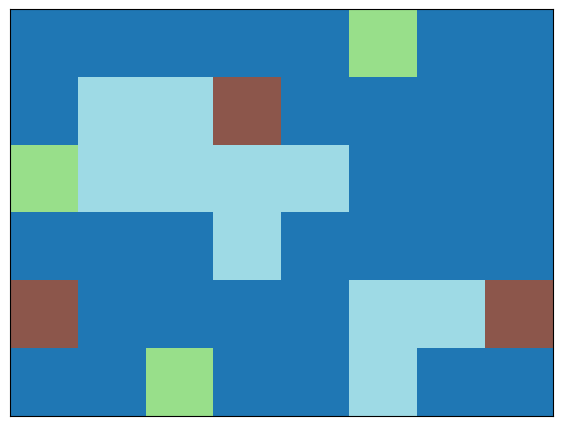

In [6]:
WIDTH = 6
HEIGHT = 8
miArchivo = open("configInicial.txt","r")

mapa = []

for i in range(6):
    linea = miArchivo.readline()
    row = []
    for i in range(8):
        row.append("".join(list(linea)[:4]))
        linea = linea[5:]
    mapa.append(row)


#print(mapa)

poi = []
for i in range(3):
    temp = []
    linea = miArchivo.readline()
    list(linea)
    temp.append(tuple([int(linea[0]), int(linea[2])]))
    if linea[4] == "v":
        temp.append(True)
    else:
        temp.append(False)
    poi.append(temp)

#print(poi)

fire = []
for i in range(10):
    linea = miArchivo.readline()
    list(linea)
    fire.append(tuple([int(linea[0]), int(linea[2])]))

#print(fire)

doors = []
for i in range(8):
    temp = []
    linea = miArchivo.readline()
    list(linea)
    temp.append(tuple([int(linea[0]), int(linea[2])]))
    temp.append(tuple([int(linea[4]), int(linea[6])]))
    doors.append(temp)

#print(doors)

entrance = []
for i in range(4):
    linea = miArchivo.readline()
    list(linea)
    entrance.append(tuple([int(linea[0]), int(linea[2])]))

#print(entrance)

configInicial = [mapa] + [poi] + [fire] + [doors] + [entrance]
#print(configInicial)

miArchivo.close()

model = Board(WIDTH, HEIGHT, configInicial)
contador = 0

# Correr la simulación
while model.running:
    model.step()
    contador+=1
"""
infoBomberos = model.datacollector.get_agent_vars_dataframe()
print(infoBomberos)
print(infoBomberos.to_json())
infoTablero = model.datacollector.get_model_vars_dataframe().to_json()
print(infoTablero)

"""
# Obtenemos la información que almacenó el colector, este nos entregará
# un DataFrame de pandas que contiene toda la información.
all_grid = model.datacollector.get_model_vars_dataframe()
#print(all_grid)
# Graficamos la información usando `matplotlib`
# %%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0,0], cmap=plt.cm.tab20)

def animate(i):
    patch.set_data(all_grid.iloc[i,0])

anim = animation.FuncAnimation(fig, animate, frames=contador)




In [7]:
anim.save("animacion.gif")
anim

MovieWriter ffmpeg unavailable; using Pillow instead.


In [8]:
#Modelo del tablero
class Board(Model):
  def __init__(self, width, height, array):
    super().__init__()
    self.grid = MultiGrid(width, height, True)
    self.schedule = BaseScheduler(self)
    self.running = True
    
    self.rescatadas = 0 #Victimas rescatadas
    self.muertos = 0 #Victimas muertas
    self.DP = 0 #Damage points de los muros
    self.victimas = 8 #Victimas restantes
    self.falsaAlarma = 4 #FA restantes

    self.JsonVictimas = [] #Coordenadas de los POI con Victimas
    self.JsonFalsaAlarma = [] #Coordenadas con los POI 
    self.map = array[0] #Mapa de las paredes del tablero
    self.poi = array[1] #Puntos de interes
    self.fire = array[2] #Casillas con fuego
    self.doors = array[3] #Casillas con puertas
    self.entrance = array[4] #Casillas con entradas
    self.smokes = [] #Casillas con humo
    self.grafo = {} #Grafo de las casillas
    self.make_graph()

    self.DW = {} #Damage walls de los muros

    
    self.datacollector = DataCollector(
      model_reporters = {"Map": "map", "Victimas": "JsonVictimas", "Fire": "fire", "Smokes": "smokes", "FA":"JsonFalsaAlarma", "Muertos":"muertos", "Rescatados":"rescatadas","DP":"DP"}, agent_reporters = {"Pos": "pos"}
    )
    """
    self.datacollector = DataCollector(
      model_reporters = {"Grid": get_grid}
    )
    """
    #Entradas
    self.start = [tuple([0,5]), tuple([2,0]), tuple([3,7]), tuple([5,2])]

    #Crea los agentes
    for i in range(0, 6, 1):
      agent = Dino(i, self)
      self.grid.place_agent(agent, self.start[np.random.randint(0,4)])
      #self.grid.place_agent(agent, (5, 7))
      self.schedule.add(agent)

  def step(self):
    print("\nStep: " + str(self.schedule.steps))

    """
    #print("Walls: "+str(self.map))
    #print("Smokes: "+str(self.smokes))
    #print("Fire: " + str(self.fire))
    #print("POI: " + str(self.poi))
    print("Rescatadas: " + str(self.rescatadas))
    print("Muertos: "+str(self.muertos))
    print("Door: "+ str(self.doors))
    print("Victimas: "+ str(self.victimas))
    print("Falsa Alarma: " + str(self.falsaAlarma))
    print("DP: " + str(self.DP))
    print("DW: "+str(self.DW))
    """
    
    self.traductor()
    if self.muertos >= 4:
      print("----GAME OVER----El juego ha terminado porque han muerto 4 Victimas")
      self.running = False
    elif self.DP >= 24:
      print("----GAME OVER----El juego ha terminado porque el edificio se ha derrumbado")
      self.running = False
    elif self.rescatadas >= 7:
      print("----SE GANO EL JUEGO---- Se han salvado 7 victimas exitosamente")
      self.running = False
    self.datacollector.collect(self)
    self.schedule.step()
    self.setFire()
    self.smoke2Fire()
    self.reveal()
    self.knockOut()
    
    #Rellena los puntos de interes
    if len(self.poi) < 3:
      self.refillPOI()
    
  def traductor(self):
    #Esta funcion se encarga de convertir los POI en tuplas de coordenadas para poder pasarlas al server y sean mas legibles

    temp1 = [] #Victima
    temp2 = [] #Falsa alarma
    for i in self.poi:
      if i[1]:
        temp1.append(i[0])
      else:
        temp2.append(i[0])

    self.JsonVictimas = temp1
    self.JsonFalsaAlarma = temp2

  def smoke2Fire(self):
    #Esta funcion se encarga de convertir todos los humos adyacentes a fuegos a fuegos

    for smoke in self.smokes:
      smokeNeighbors = self.grid.get_neighborhood(tuple([smoke[0]-1, smoke[1]-1]), moore=False, include_center=False)
      for i in smokeNeighbors: 
        if tuple([i[0]+1, i[1]+1]) in self.fire: #Si algun vecino del humo es un fuego
          self.smokes.remove(smoke) 
          self.fire.append(smoke) #Se convierte en fuego tambien
          break

  def reveal(self):
    #Revela el POI cuando un fuego se coloca en su posicion

    for element in self.poi:
      if element[0] in self.fire:
        if element[1]: #Si es una victima
          print("La revelacion era una victima!!!")
          self.muertos += 1 #Se añade al contador de muertos
          self.poi.remove(element) #Se quita el poi
        else:
          print("La revelacion era una falsa alarma")
          self.poi.remove(element) #Se quita el poi

  def refillPOI(self):
    #Esta funcion rellena los POI si es que han disminuido de 3 en el mapa
    
    temp = []
    for i in self.poi:
      temp.append(i[0])

    # Si aun hay ambos, es aleatorio si el nuevo POI sera victima o FA
    if self.victimas > 0 and self.falsaAlarma > 0:
      coin = np.random.randint(0, 2)
      if coin == 0:
        while True:
          new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
          if new not in temp:
            self.poi.append([new, False])
            self.falsaAlarma -= 1

            if new in self.smokes:
              self.smokes.remove(new)
            elif new in self.fire:
              self.fire.remove(new)

            break
      else:
        while True:
          new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
          if new not in temp:
            self.poi.append([new, True])
            self.victimas -= 1

            if new in self.smokes:
              self.smokes.remove(new)
            elif new in self.fire:
              self.fire.remove(new)

            break

    # Si no hay victimas pero si falsas alarmas
    elif self.victimas == 0 and self.falsaAlarma > 0:
      while True:
        new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
        if new not in temp:
          self.poi.append([new, False])
          self.falsaAlarma -= 1

          if new in self.smokes:
            self.smokes.remove(new)
          elif new in self.fire:
            self.fire.remove(new)

          break

    # Si hay victimas pero no falsas alarmas
    elif self.victimas > 0 and self.falsaAlarma == 0:
      while True:
        new = tuple([np.random.randint(1, 7), np.random.randint(1, 9)])
        if new not in temp:
          self.poi.append([new, True])
          self.victimas -= 1

          if new in self.smokes:
            self.smokes.remove(new)
          elif new in self.fire:
            self.fire.remove(new)

          break

  def make_graph(self):
    #Esta funcion se encarga de modificar las coordenads de las puertas para que coinicdan con el grid de 0,0 como origen
    #posterior se llama la funcion de crear grafo 

    puertas = []
    for i in range(len(self.doors)):
      temp = []
      for j in range(2):
        temp.append(tuple([self.doors[i][j][0]-1, self.doors[i][j][1]-1]))
      puertas.append(temp)
    

    self.grafo = self.crear_grafo(self.map, puertas)
    
  # Función para crear el grafo
  def crear_grafo(self, mapa, puertas):
    filas = len(mapa)
    columnas = len(mapa[0])
    grafo = {}

    # Crear grafo básico con pesos según paredes
    for i in range(filas):
        for j in range(columnas):
            nodo = (i, j)
            grafo[nodo] = []

            paredes = mapa[i][j]

            # Arriba
            if i > 0:
                peso = 8 if paredes[0] == '1' or mapa[i - 1][j][2] == '1' else 1
                grafo[nodo].append(((i - 1, j), peso))

            # Izquierda
            if j > 0:
                peso = 8 if paredes[1] == '1' or mapa[i][j - 1][3] == '1' else 1
                grafo[nodo].append(((i, j - 1), peso))

            # Abajo
            if i < filas - 1:
                peso = 8 if paredes[2] == '1' or mapa[i + 1][j][0] == '1' else 1
                grafo[nodo].append(((i + 1, j), peso))

            # Derecha
            if j < columnas - 1:
                peso = 8 if paredes[3] == '1' or mapa[i][j + 1][1] == '1' else 1
                grafo[nodo].append(((i, j + 1), peso))

    # Ajustar las conexiones de las puertas para tener peso 2
    for puerta in puertas:
        nodo1, nodo2 = puerta
        # Remover conexiones existentes entre los nodos de la puerta
        grafo[nodo1] = [(nodo, peso) for nodo, peso in grafo[nodo1] if nodo != nodo2]
        grafo[nodo2] = [(nodo, peso) for nodo, peso in grafo[nodo2] if nodo != nodo1]

        # Agregar las conexiones con peso 2
        grafo[nodo1].append((nodo2, 2))
        grafo[nodo2].append((nodo1, 2))
    
    return grafo

  def destroyWalls(self, cell, next):
    #Esta funcion se encarga de llevar un registro de las paredes golpeadas y en caso de que haya 2 contadores de daño en esa pared la destruye

    result = tuple([cell[0]-next[0], cell[1]-next[1]])

    if result == (1, 0) or result == (-1, 0):#Verifica si es hacia ariiba o abajo
      if tuple([cell, next]) in self.DW:#Si ya esta dentro del registro quiere decir que ya tiene un DP, por lo tanto se rompera esta pared
        self.DW[tuple([cell, next])] = 2

        self.map[cell[0]-1][cell[1]-1] = self.map[cell[0]-1][cell[1]-1][:-2] + "0" + self.map[cell[0]-1][cell[1]-1][-1]

        if not(self.grid.out_of_bounds(tuple([next[0]-1, next[1]-1]))):
          self.map[next[0]-1][next[1]-1] = "0" + self.map[next[0]-1][next[1]-1][1:]
        
      else:
        #Se lleva el registro de la pared dañada
        self.DW[tuple([cell, next])] = 1
    else:
      if tuple([cell, next]) in self.DW:#Si ya esta dentro del registro quiere decir que ya tiene un DP, por lo tanto se rompera esta pared
        self.DW[tuple([cell, next])] = 2

        self.map[cell[0]-1][cell[1]-1] = self.map[cell[0]-1][cell[1]-1][:-1] + "0"


        if not(self.grid.out_of_bounds(tuple([next[0]-1, next[1]]))):
          self.map[next[0]-1][next[1]] = self.map[next[0]-1][next[1]][0] + "0" + self.map[next[0]-1][next[1]][2:]

      else:
         #Se lleva el registro de la pared dañada
        self.DW[tuple([cell, next])] = 1

  def knockOut(self):
    #Esta funcion noquea a todos los agentes que se encuentren en una casilla en llamas, si el agente llevaba una victima esta morira

    for agent in self.schedule.agents:
      if tuple([agent.pos[0]+1,agent.pos[1]+1]) in self.fire:#Si su posicion del agente coincide con un fuego
        if agent.isCarring:#Si el agente lleva una victima, la victima muere
          self.muertos += 1
          agent.isCarring = False
        self.grid.move_agent(agent, self.start[np.random.randint(0,4)])#Se mueve el agente a una entrada aleatoria

  def diceRun(self):
    #Esta funcion simula tirar 2 dados

    dice1 = np.random.randint(1,7)
    dice2 = np.random.randint(1,9)
    return tuple([dice1, dice2])

  def damageWall(self, amount):
    self.DP = self.DP + amount
    """
    if amount == 1:
      print("Damage wall")
    else:
      print("Damage door")
    """

  def setFire(self): 
    #Esta funcion se encarga de colocar los fuegos y humos de manera aleatoria
    #Si el fuego aun no existe, sera un humo
    #Si el humo ya existe, se convierte en un fuego
    #Si el fuego ya existe, se realiza una explosion


    newFire = self.diceRun()#Se tiran los dados

    #Si el humo ya existe, se convierte en un fuego
    if newFire in self.smokes:
      self.fire.append(newFire)
      self.smokes.remove(newFire)

    #Si el fuego ya existe, se realiza una explosion
    elif newFire in self.fire:
      fireNeighbors = self.grid.get_neighborhood((newFire[0]-1, newFire[1]-1), moore=False, include_center=False)#Se obtiene la vecindad del fuego
      
      #Acontinuacion se realizara una verificacion en los 4 ejes del fuego, extendiendo el fuego hasta encontrar un espacio vacio
      #o una pared o una puerta (en los ultimos dos se dañara la pared y la puerta se rompera)
      for i in range(len(fireNeighbors)):
        temp = tuple([newFire[0]-1 - fireNeighbors[i][0], newFire[1]-1 - fireNeighbors[i][1]])

        if temp == (0, -1): # ---->
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][3] == "1": #Si se encuentra una pared
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]), 2): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[:-1] + "0"

                direction = self.map[kk[0]-1][kk[1]]
                self.map[kk[0]-1][kk[1]] = direction[0] + "0" + direction[2:]

                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1]))
                self.damageWall(1)


              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break
            else:
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]), 2): #Si la casilla es una puerta abierta se rompe

                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[:-1] + "0"

                direction = self.map[kk[0]-1][kk[1]]
                self.map[kk[0]-1][kk[1]] = direction[0] + "0" + direction[2:]
                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0], kk[1]+1])])

                self.damageWall(2)

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

              else:

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break


            kk = (kk[0], kk[1]+1)

        elif temp == (0, 1):# <----
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][1] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]-2), 3): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[0] + "0" + direction[2:]

                direction = self.map[kk[0]-1][kk[1]-2]
                self.map[kk[0]-1][kk[1]-2] = direction[:-1] + "0"
                self.doors.remove([tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break

            else:
              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-1, kk[1]-2), 3): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = direction[0] + "0" + direction[2:]

                direction = self.map[kk[0]-1][kk[1]-2]
                self.map[kk[0]-1][kk[1]-2] = direction[:-1] + "0"
                self.doors.remove([tuple([kk[0], kk[1]-1]), tuple([kk[0], kk[1]])])

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

                self.damageWall(2)
              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0], kk[1]-1)

        elif temp == (1, 0):# UP
          kk = newFire
          while True:
            
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break
            if self.map[kk[0]-1][kk[1]-1][0] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-2, kk[1]-1), 0): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]

                self.map[kk[0]-1][kk[1]-1] = "0" + direction[1:]

                direction = self.map[kk[0]-2][kk[1]-1]
                self.map[kk[0]-2][kk[1]-1] = direction[:-2] + "0" + direction[-1]
                self.doors.remove([tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)

              break

            else:

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0]-2, kk[1]-1), 0): #Si la casilla es una puerta cerrada se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] = "0" + direction[1:]

                direction = self.map[kk[0]-2][kk[1]-1]
                self.map[kk[0]-2][kk[1]-1] =  direction[:-2] + "0" + direction[-1]
                self.doors.remove([tuple([kk[0]-1, kk[1]]), tuple([kk[0], kk[1]])])
                self.damageWall(2)

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)

              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0]-1, kk[1])

        elif temp == (-1, 0):# DOWN
         
          kk = newFire
          while True:
            if self.grid.out_of_bounds(tuple([kk[0]-1, kk[1]-1])):
              break

            if self.map[kk[0]-1][kk[1]-1][2] == "1": #Si se encuentra una pared

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0], kk[1]-1), 1): #Si la casilla es una puerta cerrada se rompe

                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] =  direction[:-2] + "0" + direction[-1]

                direction = self.map[kk[0]][kk[1]-1]
                self.map[kk[0]][kk[1]-1] = "0" + direction[1:]

                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]])])
                self.damageWall(2)
              else:
                #Si es una pared esta se daña
                self.destroyWalls(tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]]))
                self.damageWall(1)

              if kk in self.smokes:
                self.smokes.remove(kk)
                self.fire.append(kk)
              elif kk not in self.fire:
                self.fire.append(kk)
              break
            else:

              if self.isDoor((kk[0]-1, kk[1]-1), (kk[0], kk[1]-1), 1): #Si la casilla es una puerta abierta se rompe
                direction = self.map[kk[0]-1][kk[1]-1]
                self.map[kk[0]-1][kk[1]-1] =  direction[:-2] + "0" + direction[-1]

                direction = self.map[kk[0]][kk[1]-1]
                self.map[kk[0]][kk[1]-1] = "0" + direction[1:]
                self.doors.remove([tuple([kk[0], kk[1]]), tuple([kk[0]+1, kk[1]])])

                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                elif kk not in self.fire:
                  self.fire.append(kk)
                self.damageWall(2)

              else:
                if kk in self.smokes:
                  self.smokes.remove(kk)
                  self.fire.append(kk)
                  break
                elif kk not in self.fire:
                  self.fire.append(kk)
                  break

            kk = (kk[0]+1, kk[1])

    else:
      #Si no es ninguno de las anteriores, se añade el humo
      self.smokes.append(newFire)

  def isDoor(self, pos, next, flag):
    #Esta funcion verifica si la casilla es una puerta

    if flag == 0:
      for door in self.doors:
        objective = tuple([door[0][0]-1, door[0][1]-1])
        casilla = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 1:
      for door in self.doors:
        casilla = tuple([door[0][0]-1, door[0][1]-1])
        objective = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 2:
      for door in self.doors:
        casilla = tuple([door[0][0]-1, door[0][1]-1])
        objective = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    elif flag == 3:
      for door in self.doors:
        objective = tuple([door[0][0]-1, door[0][1]-1])
        casilla = tuple([door[1][0]-1, door[1][1]-1])
        if pos == casilla and next == objective:
          return True
    return False


[[['1100', '1000', '1001', '1100', '1001', '1100', '1000', '1001'], ['0100', '0000', '0011', '0100', '0011', '0110', '0010', '0011'], ['0100', '0001', '1100', '1000', '1000', '1001', '1100', '1001'], ['0110', '0011', '0110', '0010', '0010', '0011', '0110', '0011'], ['1100', '1000', '1000', '1000', '1001', '1100', '1001', '1101'], ['0110', '0010', '0010', '0010', '0011', '0110', '0011', '0111']], [[(2, 4), True], [(5, 1), False], [(5, 8), True]], [(2, 2), (2, 3), (3, 2), (3, 3), (3, 4), (3, 5), (4, 4), (5, 6), (5, 7), (6, 6)], [[(1, 3), (1, 4)], [(2, 5), (2, 6)], [(2, 8), (3, 8)], [(3, 2), (3, 3)], [(4, 4), (5, 4)], [(4, 6), (4, 7)], [(6, 5), (6, 6)], [(6, 7), (6, 8)]], [(1, 6), (3, 1), (4, 8), (6, 3)]]

Step: 0

Step: 1

Step: 2

Step: 3

Step: 4

Step: 5

Step: 6

Step: 7

Step: 8

Step: 9

Step: 10

Step: 11
La revelacion era una victima!!!

Step: 12
La revelacion era una victima!!!

Step: 13

Step: 14

Step: 15
La revelacion era una victima!!!

Step: 16

Step: 17

Step: 18
La revela

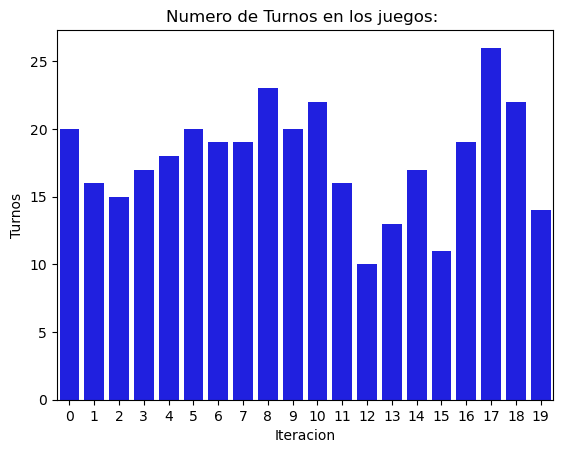

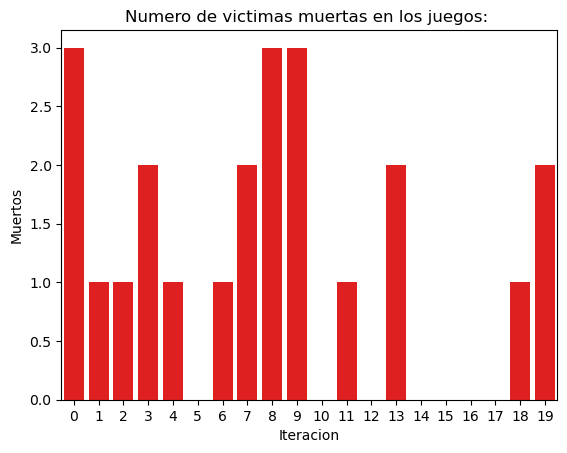

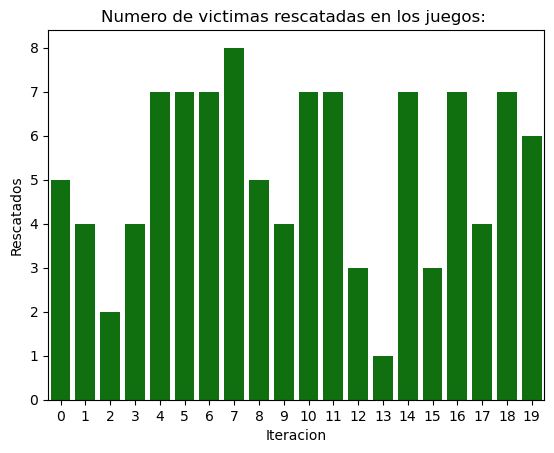

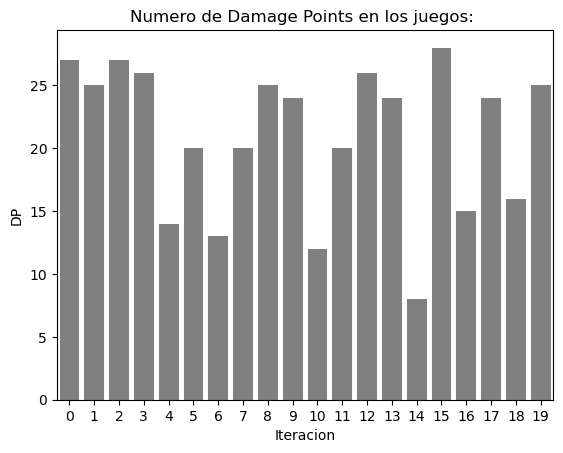

In [9]:

df = pd.DataFrame()

for j in range(20):
    WIDTH = 6
    HEIGHT = 8
    miArchivo = open("configInicial.txt","r")

    mapa = []

    for i in range(6):
        linea = miArchivo.readline()
        row = []
        for i in range(8):
            row.append("".join(list(linea)[:4]))
            linea = linea[5:]
        mapa.append(row)


    #print(mapa)

    poi = []
    for i in range(3):
        temp = []
        linea = miArchivo.readline()
        list(linea)
        temp.append(tuple([int(linea[0]), int(linea[2])]))
        if linea[4] == "v":
            temp.append(True)
        else:
            temp.append(False)
        poi.append(temp)

    #print(poi)

    fire = []
    for i in range(10):
        linea = miArchivo.readline()
        list(linea)
        fire.append(tuple([int(linea[0]), int(linea[2])]))

    #print(fire)

    doors = []
    for i in range(8):
        temp = []
        linea = miArchivo.readline()
        list(linea)
        temp.append(tuple([int(linea[0]), int(linea[2])]))
        temp.append(tuple([int(linea[4]), int(linea[6])]))
        doors.append(temp)

    #print(doors)

    entrance = []
    for i in range(4):
        linea = miArchivo.readline()
        list(linea)
        entrance.append(tuple([int(linea[0]), int(linea[2])]))

    #print(entrance)

    configInicial = [mapa] + [poi] + [fire] + [doors] + [entrance]
    print(configInicial)

    miArchivo.close()

    model = Board(WIDTH, HEIGHT, configInicial)
    contador = 0

    # Correr la simulación
    while model.running:
        model.step()
        contador+=1
    info = model.datacollector.get_model_vars_dataframe()
    
    #info.reset_index(inplace=True)
    
    del info['Map']
    del info['Victimas']
    del info['Fire']
    del info['Smokes']
    del info['FA']
    info.reset_index(inplace=True)
    info['Iteracion'] = j
    
    df = pd.concat([df, (info[(info.index==contador-1)])])

print(df)

sns.barplot(x="Iteracion", y="index", data=df, color='blue')
plt.xlabel("Iteracion")
plt.ylabel("Turnos")
plt.title("Numero de Turnos en los juegos: ")
plt.show()

sns.barplot(x="Iteracion", y="Muertos", data=df, color='red')
plt.xlabel("Iteracion")
plt.ylabel("Muertos")
plt.title("Numero de victimas muertas en los juegos: ")
plt.show()

sns.barplot(x="Iteracion", y="Rescatados", data=df, color='green')
plt.xlabel("Iteracion")
plt.ylabel("Rescatados")
plt.title("Numero de victimas rescatadas en los juegos: ")
plt.show()

sns.barplot(x="Iteracion", y="DP", data=df, color='gray')
plt.xlabel("Iteracion")
plt.ylabel("DP")
plt.title("Numero de Damage Points en los juegos: ")
plt.show()